**Goal**<br>
The goal of this exercise is to train a ResNet18 model on MNIST and to track throughout the epochs of SGD the convergence to Neural Collapse.

*Warning: once implemented, running the code will take some time.*

*Before you start, make sure to change the runtime type to include a GPU!*

<br>

**Task (adding 5-8 lines of code)**<br>
Update in the appropriate locations in the code:
* the (unnormalized) feature class means
* the (unnormalized) feature within-class covariance
* the number of examples in each class

Hints:
* **Notice that some mini-batches might contain no examples in certain classes.**
* the function torch.nonzero is useful for finding which examples in a mini-batch belong to a certain class
* the function torch.sum is useful for updating the class means and the within-class covariance
* the function torch.matmul is useful for updating the within-class covariance
* the function torch.stack might be useful
* you might want to loop over the training examples in each mini-batch

<br>

**Submission**<br>
*   Download your code by clicking File -> Download .ipynb
*   Submit on Quercus:
    * Your downloaded ipynb file
    * PDF file of your code
    * The graphs you obtained.

In [20]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

from scipy.sparse.linalg import svds
from torchvision import datasets, transforms

%matplotlib inline

In [21]:
# hyperparameters
device          = "cuda"
epochs          = 32
lr              = 0.0679
batch_size      = 128
momentum        = 0.9
weight_decay    = 5e-4
C               = 10

In [22]:
# deep network
model = models.resnet18(pretrained=False, num_classes=10)
model.conv1 = nn.Conv2d(1, model.conv1.weight.shape[0], 3, 1, 1, bias=False)
model.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
model = model.to(device)

class features:
    pass

def hook(self, input, output):
    features.value = input[0].clone()

# register hook that saves last-layer input into features
classifier = model.fc
classifier.register_forward_hook(hook)

# dataset loaders
transform = transforms.Compose([transforms.Pad(2),
                                transforms.ToTensor(),
                                transforms.Normalize(0.1307,0.3081)])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', download=True, train=True, transform=transform), 
    batch_size=batch_size, shuffle=True, drop_last=True)

# loss function
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

# learning rate scheduler
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                              milestones=[epochs//3, (epochs*3)//3],
                                              gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [23]:
Sw_invSb = []
norm_M_CoV = []
cos_M = []
W_M_dist = []

# iterate over epochs
for epoch in range(1, epochs+1):
    # train phase
    model.train()
    accuracy = 0
    N = 0

    # iterate over train data
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        logits = model(images)
        loss = loss_function(logits, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(logits,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

        print('Train\t\tEpoch: {} \t'
              'Batch {}/{} ({:.0f}%) \t'
              'Batch Loss: {:.6f} \t'
              'Batch Accuracy: {:.6f}'.format(
                  epoch,
                  batch_idx,
                  len(train_loader),
                  100. * batch_idx / len(train_loader),
                  loss.item(),
                  100. * accuracy/N))
    lr_scheduler.step()

    

    model.eval()

    mean = [0 for _ in range(C)]
    Sw = 0
    examples_in_class = [0 for _ in range(C)]
    for computation in ['Mean','Cov']:
        for batch_idx, (data, labels) in enumerate(train_loader, start=1):
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            h = features.value.data.view(data.shape[0],-1) # B CHW

            # data (128, 1, 32, 32)
            # labels (128,)
            # output (128, 10)
            # h (128, 512)
            
            for c in range(C):
                # TASK: ADD CODE HERE
                
                if computation == 'Mean':
                    # TASK: ADD CODE HERE
                    examples_in_class[c] += labels[labels == c].shape[0]
                    mean[c] += h[labels == c].sum(dim=0)
                    
                elif computation == 'Cov':
                    # TASK: ADD CODE HERE
                    q = h[labels == c] - mean[c] # q_c = h_c - mu_c
                    q = q.unsqueeze(dim=-1) # (128, 512, 1)
                    
                    Sw += torch.bmm(q, q.transpose(dim0=-2, dim1=-1)).sum(dim=0) # (512, 512)

        
        # normalize the sum by the number of contributions
        if computation == 'Mean':
            for c in range(C):
                mean[c] /= examples_in_class[c]
                M = torch.stack(mean).T
        elif computation == 'Cov':
            Sw /= sum(examples_in_class)

    # global mean
    muG = torch.mean(M, dim=1, keepdim=True) # CHW 1
    
    # between-class covariance
    M_ = M - muG
    Sb = torch.matmul(M_, M_.T) / C

    # NC1: activation collapse
    Sw = Sw.cpu().numpy()
    Sb = Sb.cpu().numpy()
    eigvec, eigval, _ = svds(Sb, k=C-1)
    inv_Sb = eigvec @ np.diag(eigval**(-1)) @ eigvec.T 
    Sw_invSb.append(np.trace(Sw @ inv_Sb) / C)

    # NC2: convergence of class means to Simplex ETF
    M_norms = torch.norm(M_,  dim=0)
    norm_M_CoV.append((torch.std(M_norms)/torch.mean(M_norms)).item())

    def coherence(V): 
        G = V.T @ V
        G += torch.ones((C,C),device=device) / (C-1)
        G -= torch.diag(torch.diag(G))
        return torch.norm(G,1).item() / (C*(C-1))
    cos_M.append(coherence(M_/M_norms))

    # NC3: self duality
    W  = classifier.weight
    normalized_M = M_ / torch.norm(M_,'fro')
    normalized_W = W.T / torch.norm(W.T,'fro')
    W_M_dist.append((torch.norm(normalized_W - normalized_M)**2).item())

Streaming output truncated to the last 5000 lines.
Train		Epoch: 22 	Batch 149/468 (32%) 	Batch Loss: 0.000977 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 150/468 (32%) 	Batch Loss: 0.001137 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 151/468 (32%) 	Batch Loss: 0.001248 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 152/468 (32%) 	Batch Loss: 0.000785 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 153/468 (33%) 	Batch Loss: 0.001139 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 154/468 (33%) 	Batch Loss: 0.000733 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 155/468 (33%) 	Batch Loss: 0.001428 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 156/468 (33%) 	Batch Loss: 0.001029 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 157/468 (34%) 	Batch Loss: 0.002160 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 158/468 (34%) 	Batch Loss: 0.001120 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 159/468 (34%) 	Batch Loss: 0.001651 	Batch Ac

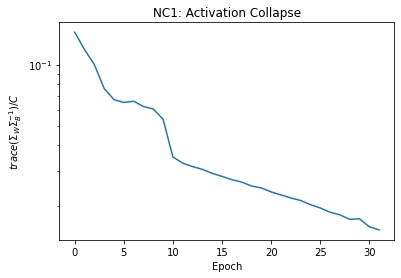

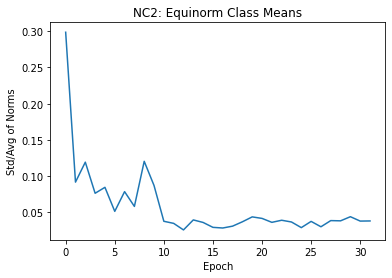

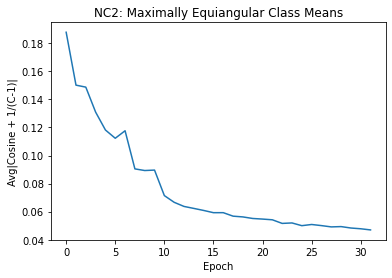

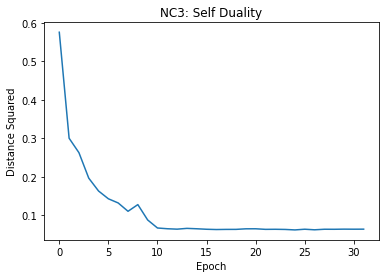

In [25]:
plt.figure(1)
plt.semilogy(Sw_invSb)
plt.xlabel('Epoch')
plt.ylabel('$trace(\Sigma_W \Sigma_B^{-1}) / C$')
plt.title('NC1: Activation Collapse')
plt.savefig('NC1.png')

plt.figure(2)
plt.plot(norm_M_CoV)
plt.xlabel('Epoch')
plt.ylabel('Std/Avg of Norms')
plt.title('NC2: Equinorm Class Means')
plt.savefig('NC2_1.png')

plt.figure(3)
plt.plot(cos_M)
plt.xlabel('Epoch')
plt.ylabel('Avg|Cosine + 1/(C-1)|')
plt.title('NC2: Maximally Equiangular Class Means')
plt.savefig('NC2_2.png')

plt.figure(4)
plt.plot(W_M_dist)
plt.xlabel('Epoch')
plt.ylabel('Distance Squared')
plt.title('NC3: Self Duality')
plt.savefig('NC3.png')

plt.show()